<a href="https://colab.research.google.com/github/AmaleshV/Elliptic/blob/master/elliptic_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Increase RAM

In [ ]:
#not mandatory if and only to increase the ram from 12GB to 26GB
d=[]
while(1):
  d.append('1')

In [ ]:
#reset variables if you've any predefined variables
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Mount google drive

In [1]:
#not necessary if you use gdown to download the files
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [15]:
from os import chdir, getcwd
print(getcwd())

/content


# From Drive

In [2]:
#Downloading elliptic dataset
!pip install gdown
!gdown --id 1GE6WIhTkFpzWym1wdtYUyT4AolAtYyhu
!unzip elliptic-data-set.zip

Downloading...
From: https://drive.google.com/uc?id=1GE6WIhTkFpzWym1wdtYUyT4AolAtYyhu
To: /content/elliptic-data-set.zip
153MB [00:01, 126MB/s] 
Archive:  elliptic-data-set.zip
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  


In [ ]:
#download all embeddings that have been pretrained to use in methodology 1
!gdown --id 1-PsY78oX3I72lHpGfHfzVxDU8CoHkUlw
!unzip embeddings.zip

# Install required packages

In [3]:
#@title
#@markdown <h3>⬅️Import Packages</h3>
!pip install node2vec
import matplotlib.pyplot as plt
import networkx as nx
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
from node2vec import Node2Vec
import node2vec
import numpy as np
import numpy
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,cohen_kappa_score,precision_score,recall_score,confusion_matrix
from sklearn.model_selection import ParameterGrid, ParameterSampler
from time import time
from sklearn.metrics import classification_report,recall_score,precision_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import itemfreq
import plotly.offline as py 
import plotly.graph_objs as go
!pip install eif
!pip install pyod
from pyod.models import *
from pyod.utils.example import *
import pandas as pd
import numpy as np
# Import unsupervised classification models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.cof import COF
from pyod.models.lmdd import LMDD
from pyod.models.loda import LODA
from pyod.models.loci import LOCI
from pyod.models.lscp import LSCP
from pyod.models.mcd import MCD
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sod import SOD
from pyod.models.so_gaal import SO_GAAL
from pyod.models.sos import SOS
from pyod.models.vae import VAE
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc

# Read the csv files

In [5]:
%%time
edges = pd.read_csv('/content/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv',engine='python')
features = pd.read_csv('/content/elliptic_bitcoin_dataset/elliptic_txs_features.csv',engine='python',header=None)
classes = pd.read_csv('/content/elliptic_bitcoin_dataset/elliptic_txs_classes.csv',engine='python')

CPU times: user 32.5 s, sys: 4.09 s, total: 36.5 s
Wall time: 37.3 s


In [ ]:
display(edges.head(5),features.head(5),classes.head(5))

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,-0.049707,-0.164402,-0.028741,-0.035391,-0.042955,-0.013282,-0.057195,-0.169609,-0.171154,-0.174473,-1.373657,-1.371460,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.120950,-0.199145,-0.187993,-0.212948,1.064205,1.063787,-1.373782,-1.354735,-0.297975,-1.403698,1.342003,1.340733,-0.171601,-0.458162,-0.423588,-0.440883,-1.015963,-1.016230,-0.968903,-0.375715,0.759748,-0.768329,1.488113,1.487932,-0.216814,-0.605631,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.077909,-0.093120,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.9689

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


# Building the graph

In [6]:
#reference of https://www.kaggle.com/dhruvrnaik/illicit-transaction-detection
len(edges),len(features),len(classes)
display(edges.head(5),features.head(5),classes.head(5))

#defining features
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + tx_features + agg_features
features = pd.merge(features,classes,left_on="txId",right_on="txId",how='left')
features['class'] = features['class'].apply(lambda x: '0' if x == "unknown" else x)

#class counts
features.groupby('class').size()
count_by_class = features[["time_step",'class']].groupby(['time_step','class']).size().to_frame().reset_index()

#categorising the class
illicit_count = count_by_class[count_by_class['class'] == '1']
licit_count = count_by_class[count_by_class['class'] == '2']
unknown_count = count_by_class[count_by_class['class'] == "0"]

#Building graph
ids = features['txId']
short_edges = edges[edges['txId1'].isin(ids)]
graph = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,-0.049707,-0.164402,-0.028741,-0.035391,-0.042955,-0.013282,-0.057195,-0.169609,-0.171154,-0.174473,-1.373657,-1.371460,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.120950,-0.199145,-0.187993,-0.212948,1.064205,1.063787,-1.373782,-1.354735,-0.297975,-1.403698,1.342003,1.340733,-0.171601,-0.458162,-0.423588,-0.440883,-1.015963,-1.016230,-0.968903,-0.375715,0.759748,-0.768329,1.488113,1.487932,-0.216814,-0.605631,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.077909,-0.093120,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.9689

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [11]:
graph.number_of_nodes()

203769

# First Approach 

Firstly, we generate embeddings on the whole graph we can generate embeddings using sections Node2Vec, LINE and ProNE. We can also use pre-trained embeddings that can be downloaded directly from 'From Drive' section above

# Node2vec

In [ ]:
i= [0.25,0.5,0.75,1]
j= [0.1,  1, 10, 100]
for p in i:
    for q in j:
        node2vec = Node2Vec(graph, dimensions = 128, p=p, q=q, 
                                        workers=1)
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        #extracting embeddings for anomaly detection
        node2vec_dict = {}
        for node in graph.nodes():
            node = str(node)
            node2vec_dict[node] = model.wv[node]
        
        node2vec_pd = pd.DataFrame.from_dict(node2vec_dict, orient='index')
        node2vec_pd.to_csv(r'/content/drive/My Drive/Thesis/node2vecp{}q{}.csv'.format(p,q))


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


# LINE

In [ ]:
!python setup.py install
!python line-elliptic.py
line_dict = {}
#G is the graph input 
for node in G.nodes():
    node = str(node)
    line_dict[node] = node2vec_d_32_w_10[node]
line_all = pd.DataFrame.from_dict(line_dict, orient='index')
line_all.to_csv(r'LINE.csv')

# ProNE

In [ ]:
!git clone https://github.com/lykeven/ProNE
os.chdir("/content/drive/My Drive/ProNE")
!pip install -r requirements.txt
!mkdir emb

!python proNE.py -graph data/ProNE.txt -emb1 emb/PPI_sparse.emb -emb2 emb/PPI_spectral.emb -dimension 128 -step 10 -theta 0.5 -mu 0.2
!python classifier.py -label data/ProNE.txt -emb emb/PPI_spectral.emb -shuffle 4

# Zip all the embeddings

In [ ]:
!zip -r '/content/drive/My Drive/embeddings.zip' '/content/drive/My Drive/Thesis'

# Anomaly detection on the node embeddings


precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.07715251541061842
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.08536853685368537
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.4772513592062221
ROC_AUC curve


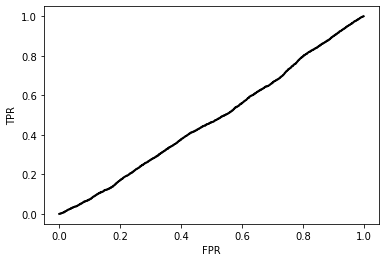

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09003589965149295
PR-AUC


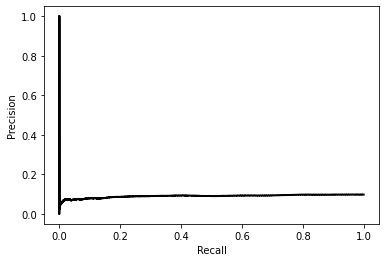

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.07556174189699741
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.08360836083608361
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4771085876049943
ROC_AUC curve


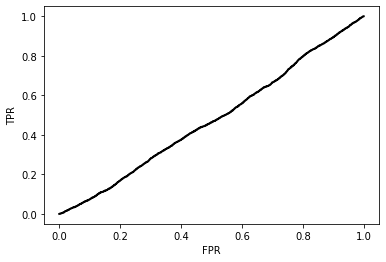

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.08999497342738697
PR-AUC


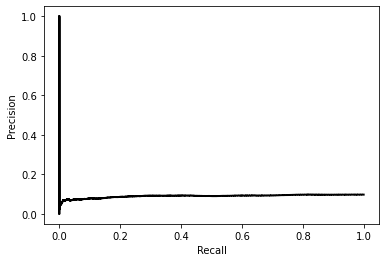

precision of Isolation Forest is 0.08112944919467091
recall of Isolation Forest is 0.08976897689768977
ROC of Isolation Forest is 0.47516277080479413
ROC_AUC curve


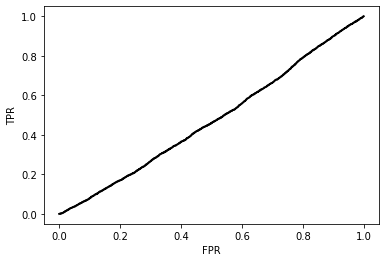

Precision-recall AUC of Isolation Forest is 0.08995164226581785
PR-AUC


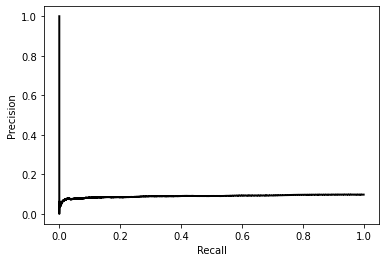

precision of Principal Component Analysis (PCA) Outlier Detector is 0.07635712865380792
recall of Principal Component Analysis (PCA) Outlier Detector is 0.08448844884488449
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.4707928581001559
ROC_AUC curve


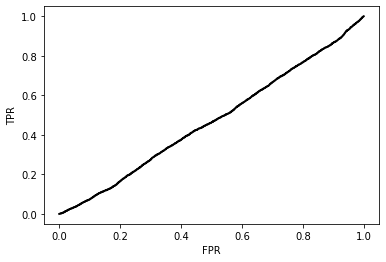

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.08924614276727878
PR-AUC


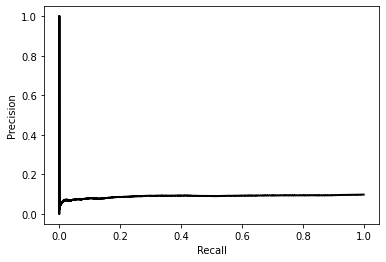

In [7]:
#@title
#@markdown <h3>⬅️ LINE</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/line.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.0753628952077948
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.08338833883388339
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.4696538741667784
ROC_AUC curve


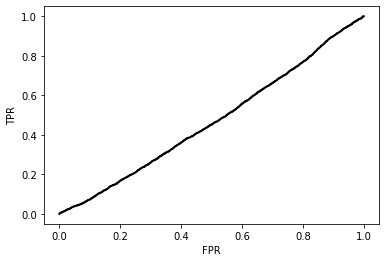

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.08991852120262571
PR-AUC


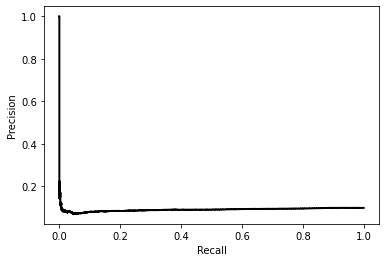

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.03459932392125671
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.03828382838283828
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4449877158876553
ROC_AUC curve


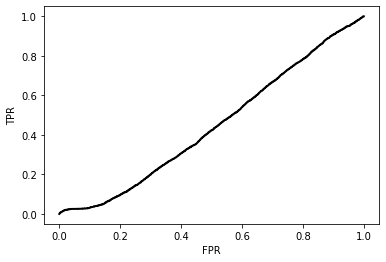

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.08359047615977269
PR-AUC


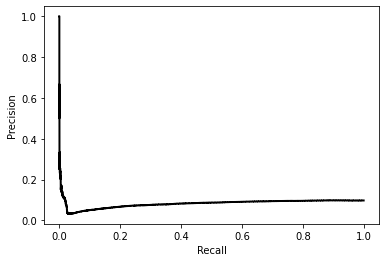

precision of Isolation Forest is 0.0914694770332074
recall of Isolation Forest is 0.10121012101210121
ROC of Isolation Forest is 0.4748918891032348
ROC_AUC curve


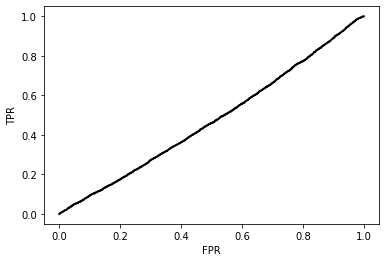

Precision-recall AUC of Isolation Forest is 0.09226185640694422
PR-AUC


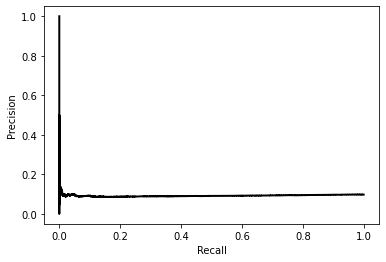

precision of Principal Component Analysis (PCA) Outlier Detector is 0.08331676277589978
recall of Principal Component Analysis (PCA) Outlier Detector is 0.09218921892189219
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.46894495394469127
ROC_AUC curve


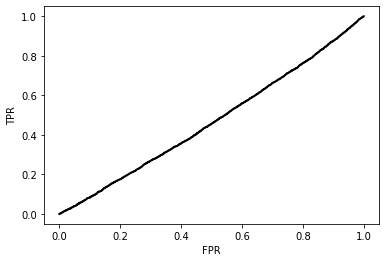

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09022361532402268
PR-AUC


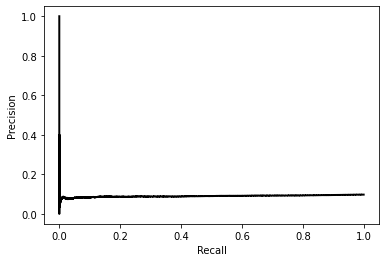

In [9]:
#@title
#@markdown <h3>⬅️ prone</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/ProNE_csv.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
#del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09942334460131239
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.11001100110011001
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.4775300376845081
ROC_AUC curve


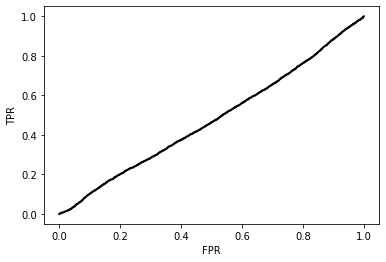

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09317731019319432
PR-AUC


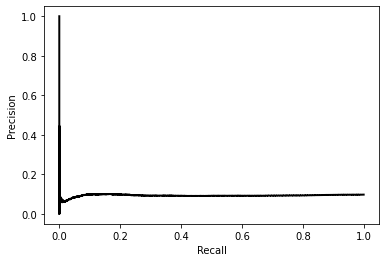

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.09763372439848876
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.10803080308030803
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.47969333166925293
ROC_AUC curve


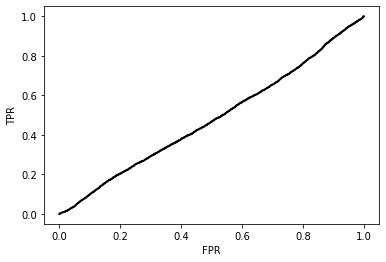

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09378376602727927
PR-AUC


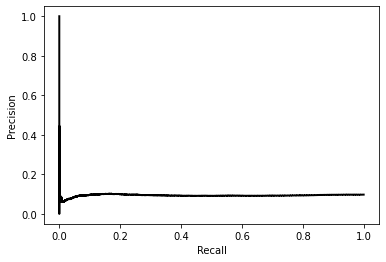

precision of Isolation Forest is 0.09763372439848876
recall of Isolation Forest is 0.10803080308030803
ROC of Isolation Forest is 0.4794089666231194
ROC_AUC curve


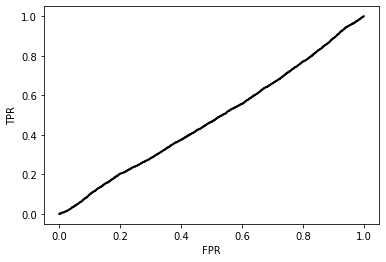

Precision-recall AUC of Isolation Forest is 0.09297888490172136
PR-AUC


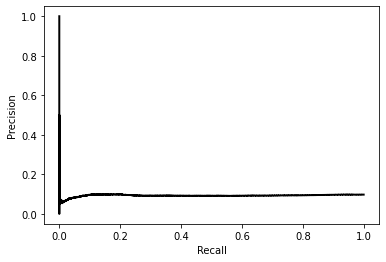

precision of Principal Component Analysis (PCA) Outlier Detector is 0.09743487770928615
recall of Principal Component Analysis (PCA) Outlier Detector is 0.1078107810781078
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.47538652101722234
ROC_AUC curve


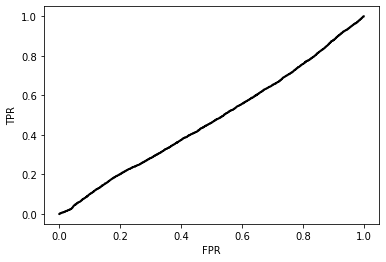

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.092934936026258
PR-AUC


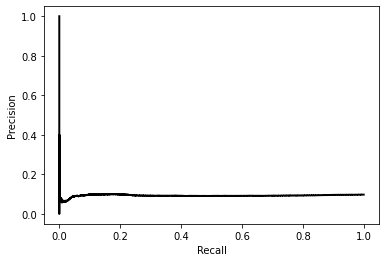

In [12]:
#@title
#@markdown <h3>⬅️d=16,w=10</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vec_d_16_w_10.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.08212368264068404
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09086908690869087
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.4710656457968317
ROC_AUC curve


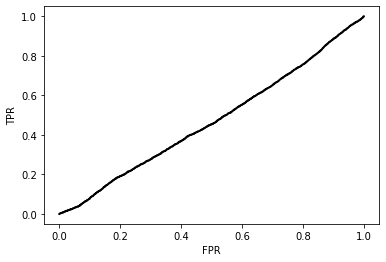

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09042900288769876
PR-AUC


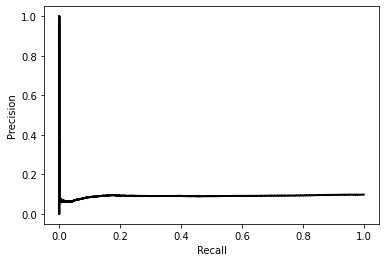

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.08470868960031816
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.09372937293729373
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.47822269411310103
ROC_AUC curve


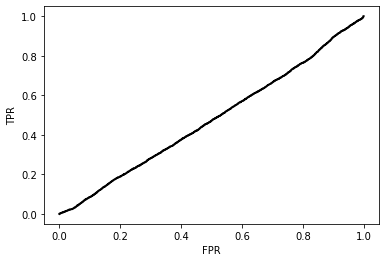

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09179059688436328
PR-AUC


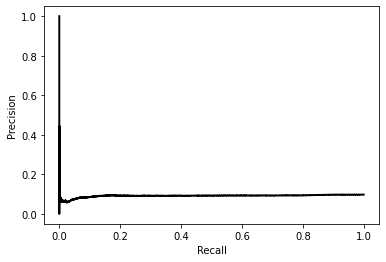

precision of Isolation Forest is 0.08252137601908928
recall of Isolation Forest is 0.09130913091309131
ROC of Isolation Forest is 0.47067083514082153
ROC_AUC curve


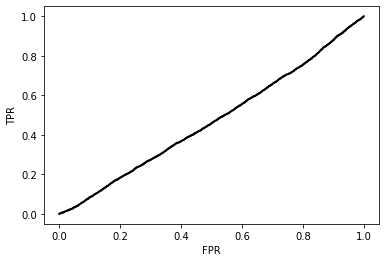

Precision-recall AUC of Isolation Forest is 0.09007868576133435
PR-AUC


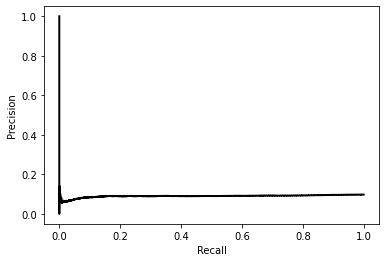

precision of Principal Component Analysis (PCA) Outlier Detector is 0.07993636905945516
recall of Principal Component Analysis (PCA) Outlier Detector is 0.08844884488448845
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.46879003947897113
ROC_AUC curve


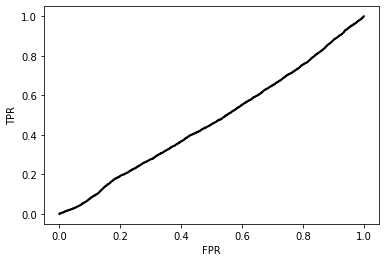

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.08997704284067508
PR-AUC


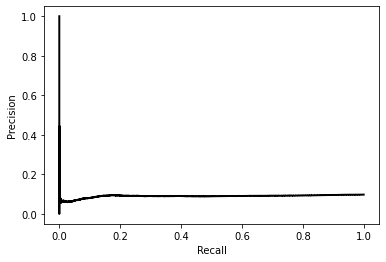

In [13]:
#@title
#@markdown <h3>⬅️d=16,w=4</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vec_d_16_w_4.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09107178365480215
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10077007700770077
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.4760256472587928
ROC_AUC curve


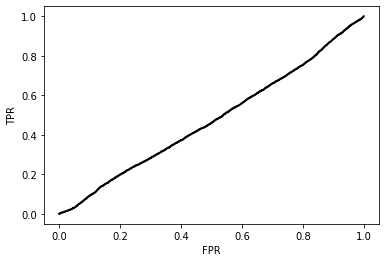

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09239380962555166
PR-AUC


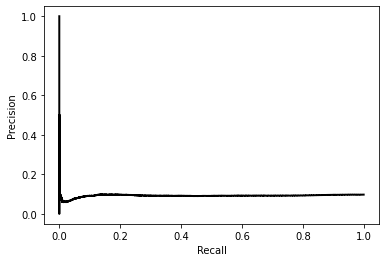

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.0930602505468284
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.10297029702970296
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.47721327072139375
ROC_AUC curve


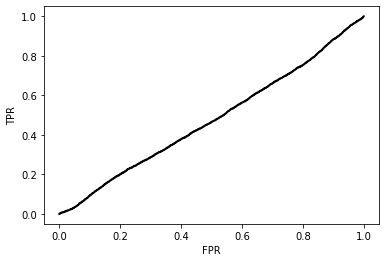

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09269934417755352
PR-AUC


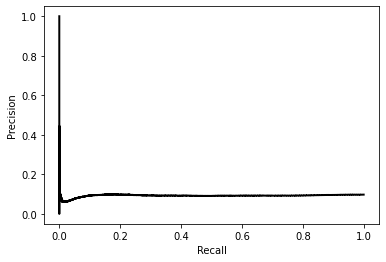

precision of Isolation Forest is 0.09047524358719428
recall of Isolation Forest is 0.1001100110011001
ROC of Isolation Forest is 0.4735631382220066
ROC_AUC curve


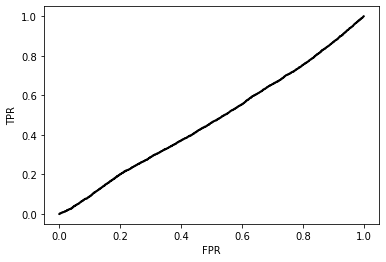

Precision-recall AUC of Isolation Forest is 0.09246905218154311
PR-AUC


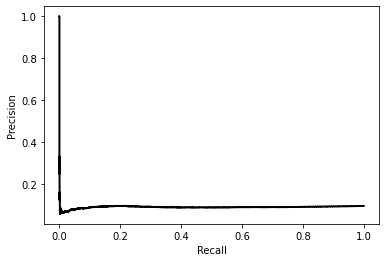

precision of Principal Component Analysis (PCA) Outlier Detector is 0.09186717041161264
recall of Principal Component Analysis (PCA) Outlier Detector is 0.10165016501650165
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.4715341854754742
ROC_AUC curve


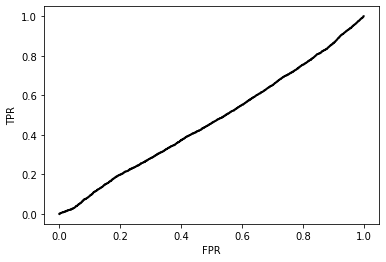

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09169455327588506
PR-AUC


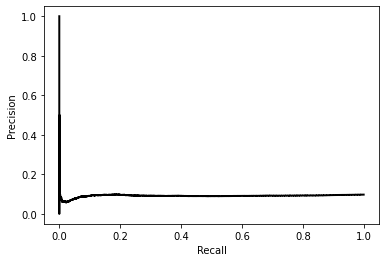

In [14]:
#@title
#@markdown <h3>⬅️d=32,w=10</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vec_d_32_w_10.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.08272022270829191
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09152915291529153
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.470798240965485
ROC_AUC curve


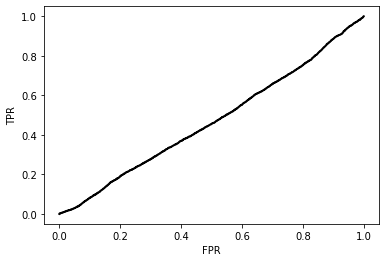

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09049556679324881
PR-AUC


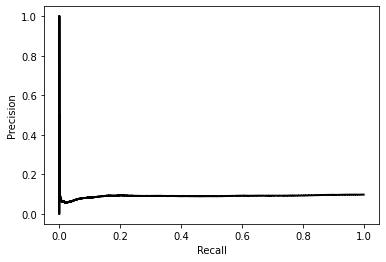

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.08172598926227878
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.09042904290429044
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.46841834948624916
ROC_AUC curve


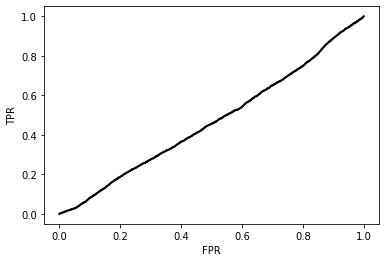

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.08995180648694182
PR-AUC


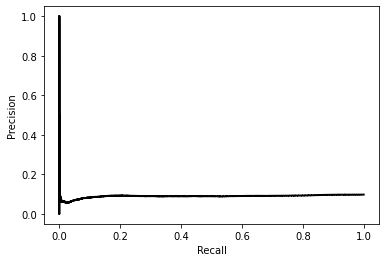

precision of Isolation Forest is 0.07894213561344203
recall of Isolation Forest is 0.08734873487348735
ROC of Isolation Forest is 0.46847849829367616
ROC_AUC curve


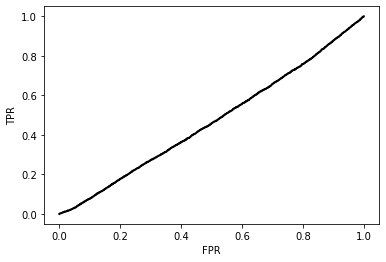

Precision-recall AUC of Isolation Forest is 0.08936990422671162
PR-AUC


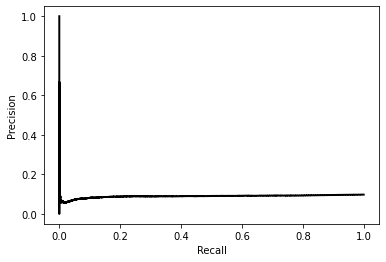

precision of Principal Component Analysis (PCA) Outlier Detector is 0.08152714257307615
recall of Principal Component Analysis (PCA) Outlier Detector is 0.09020902090209021
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.4683823607377992
ROC_AUC curve


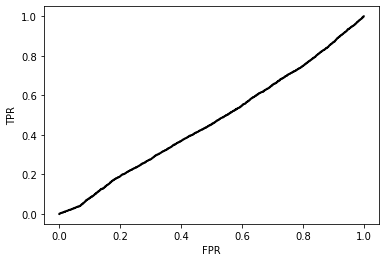

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09021301736799259
PR-AUC


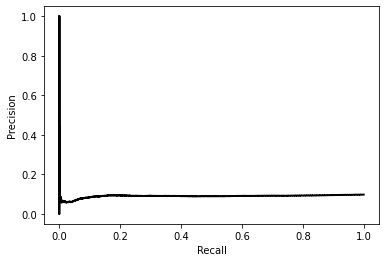

In [15]:
#@title
#@markdown <h3>⬅️d=32,w=4</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vec_d_32_w_4.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10697951879101213
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.11837183718371837
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.48408072821370995
ROC_AUC curve


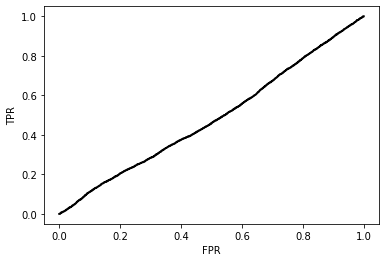

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.0952552491621601
PR-AUC


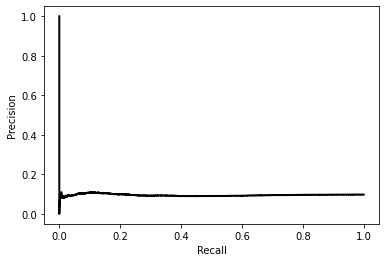

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10857029230463312
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.12013201320132014
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4841489460828803
ROC_AUC curve


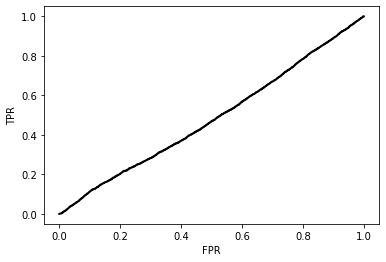

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09516329666761722
PR-AUC


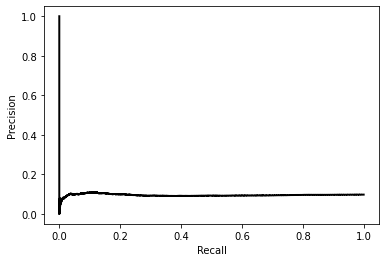

precision of Isolation Forest is 0.10717836548021475
recall of Isolation Forest is 0.1185918591859186
ROC of Isolation Forest is 0.4824850437636638
ROC_AUC curve


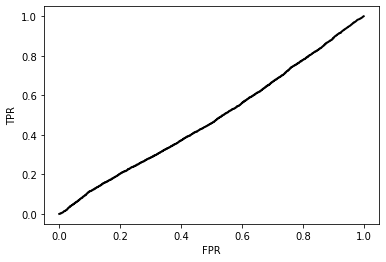

Precision-recall AUC of Isolation Forest is 0.09511107006612304
PR-AUC


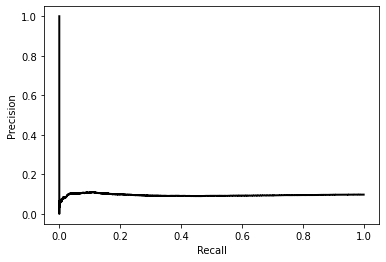

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10737721216941738
recall of Principal Component Analysis (PCA) Outlier Detector is 0.1188118811881188
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5094390402413953
ROC_AUC curve


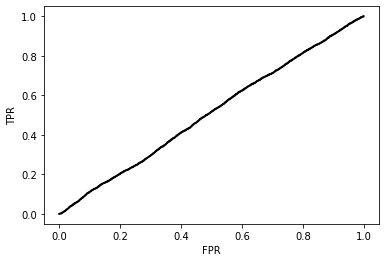

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09911607993928022
PR-AUC


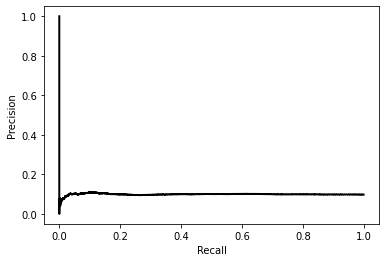

In [10]:
#@title
#@markdown <h3>⬅️p0.25q0.1</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.25q0.1.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10916683237224101
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.12079207920792079
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.48432663300124257
ROC_AUC curve


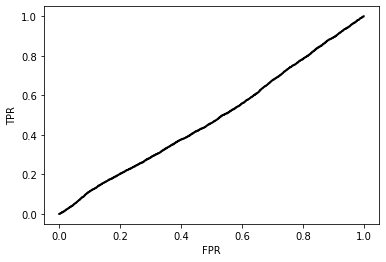

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09546078927996374
PR-AUC


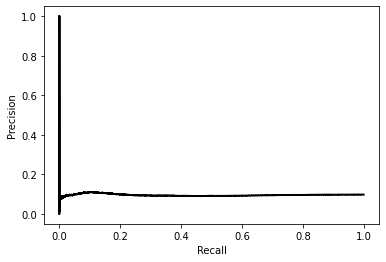

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10797375223702525
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.11947194719471947
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4845968339902602
ROC_AUC curve


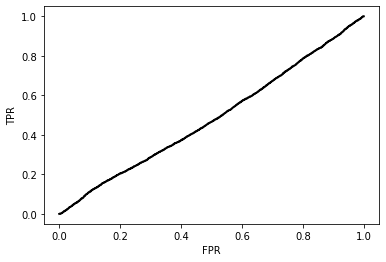

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09521669197371985
PR-AUC


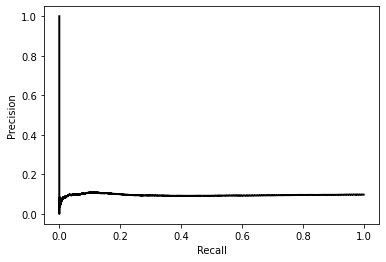

precision of Isolation Forest is 0.1067806721018095
recall of Isolation Forest is 0.11815181518151815
ROC of Isolation Forest is 0.48348766002995497
ROC_AUC curve


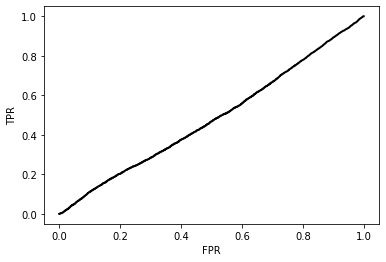

Precision-recall AUC of Isolation Forest is 0.0951898563764997
PR-AUC


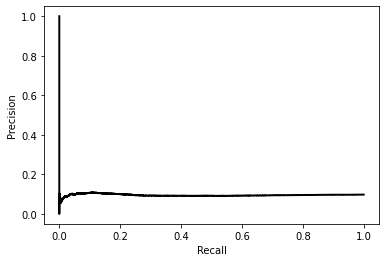

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10757605885862001
recall of Principal Component Analysis (PCA) Outlier Detector is 0.11903190319031903
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5087246481377237
ROC_AUC curve


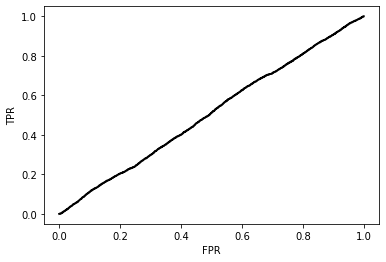

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09905990574850654
PR-AUC


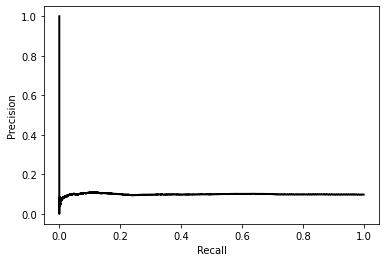

In [11]:
#@title
#@markdown <h3>⬅️p0.25q1</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.25q1.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.11016106581825412
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.12189218921892189
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.4850388782422829
ROC_AUC curve


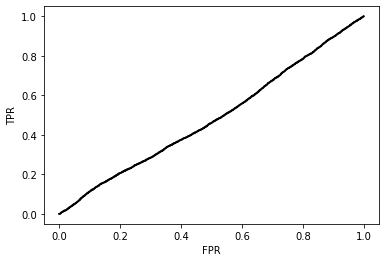

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09576792258006868
PR-AUC


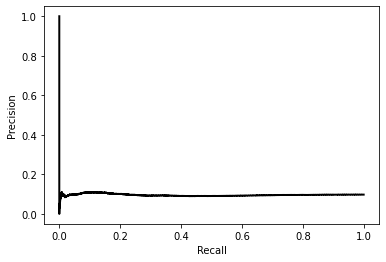

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10717836548021475
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.1185918591859186
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.48422171948982895
ROC_AUC curve


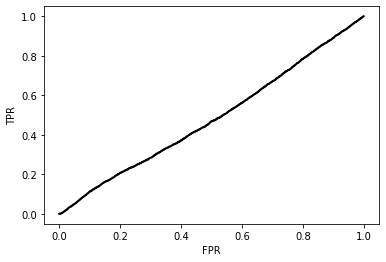

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09523786970980727
PR-AUC


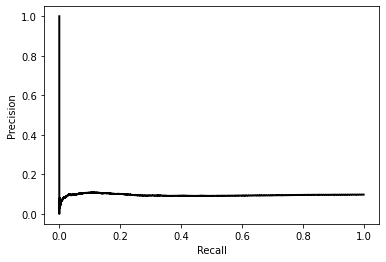

precision of Isolation Forest is 0.10538874527739113
recall of Isolation Forest is 0.11661166116611661
ROC of Isolation Forest is 0.4841554652145288
ROC_AUC curve


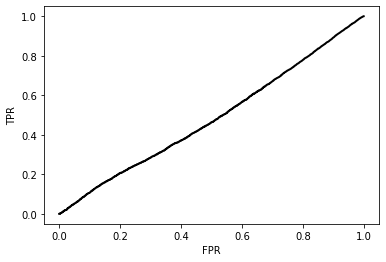

Precision-recall AUC of Isolation Forest is 0.09560260249053344
PR-AUC


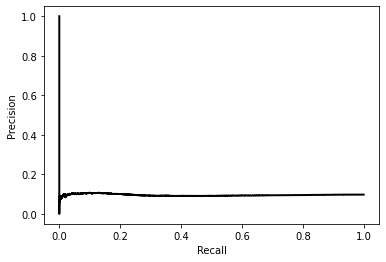

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10717836548021475
recall of Principal Component Analysis (PCA) Outlier Detector is 0.1185918591859186
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5099840396472118
ROC_AUC curve


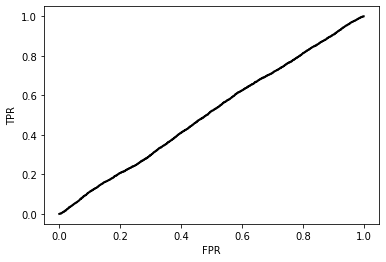

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09932664680689031
PR-AUC


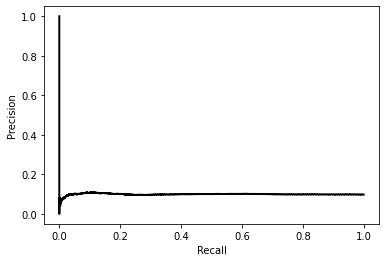

In [17]:
#@title
#@markdown <h3>⬅️p0.25q10</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.25q10.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10797375223702525
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.11947194719471947
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.484906312092929
ROC_AUC curve


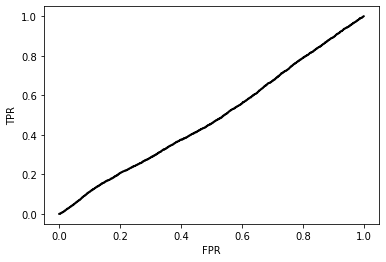

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09554047824961887
PR-AUC


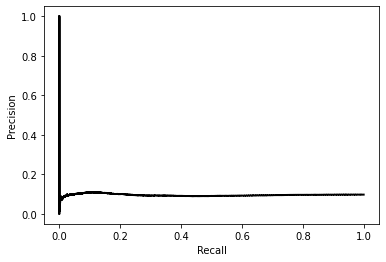

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10797375223702525
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.11947194719471947
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4848270195543317
ROC_AUC curve


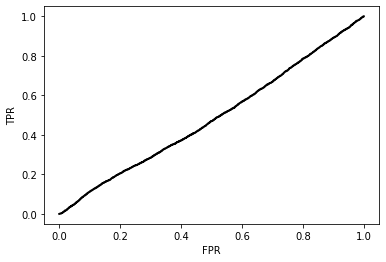

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09536735574260101
PR-AUC


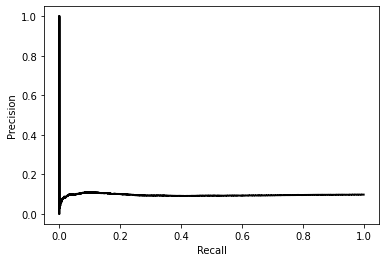

precision of Isolation Forest is 0.10618413203420163
recall of Isolation Forest is 0.11749174917491749
ROC of Isolation Forest is 0.4848610447089118
ROC_AUC curve


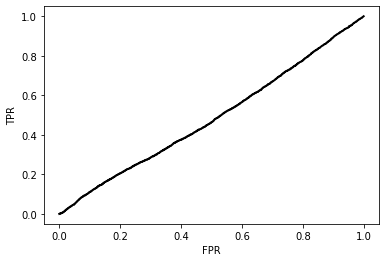

Precision-recall AUC of Isolation Forest is 0.09557894470753157
PR-AUC


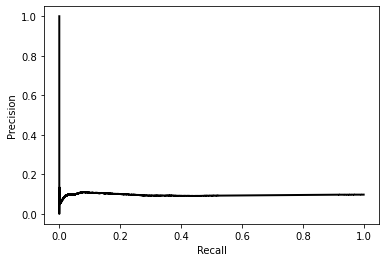

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10797375223702525
recall of Principal Component Analysis (PCA) Outlier Detector is 0.11947194719471947
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5109117304076727
ROC_AUC curve


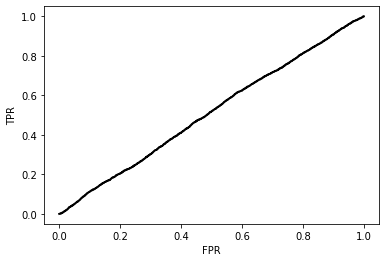

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09952171418500176
PR-AUC


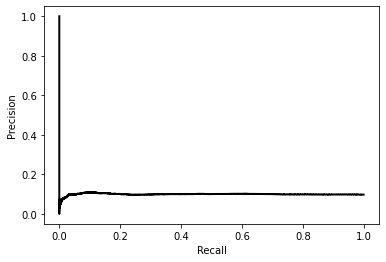

In [16]:
#@title
#@markdown <h3>⬅️p0.25q100</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.25q100.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10976337243984888
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.12145214521452145
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.4831183315861275
ROC_AUC curve


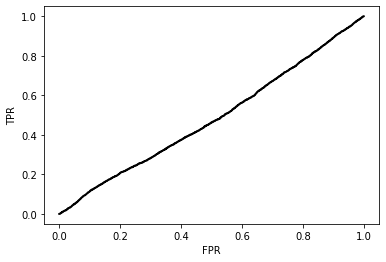

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09545315018598764
PR-AUC


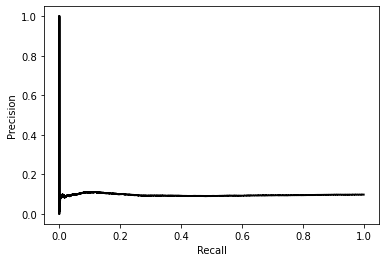

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10936567906144362
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.12101210121012101
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.48350879877249725
ROC_AUC curve


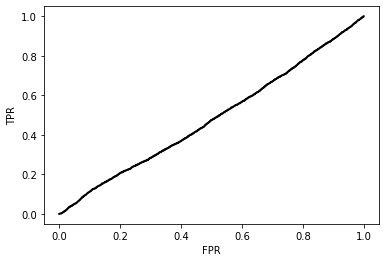

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09522976182781712
PR-AUC


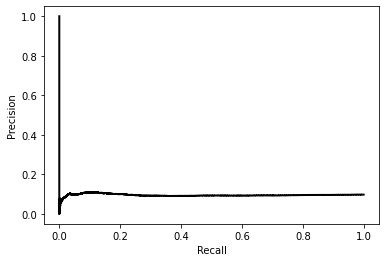

precision of Isolation Forest is 0.10797375223702525
recall of Isolation Forest is 0.11947194719471947
ROC of Isolation Forest is 0.4854126862982593
ROC_AUC curve


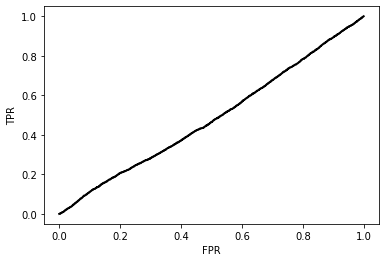

Precision-recall AUC of Isolation Forest is 0.09553573641748346
PR-AUC


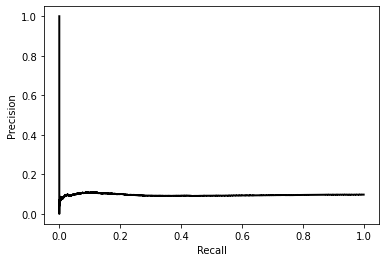

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10936567906144362
recall of Principal Component Analysis (PCA) Outlier Detector is 0.12101210121012101
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5087627052050501
ROC_AUC curve


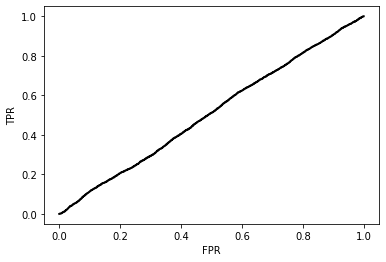

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09912634933837093
PR-AUC


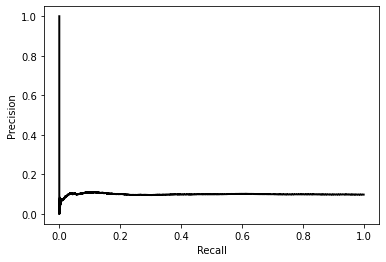

In [18]:
#@title
#@markdown <h3>⬅️p0.5q0.1</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.5q0.1.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10757605885862001
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.11903190319031903
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.48252004286080336
ROC_AUC curve


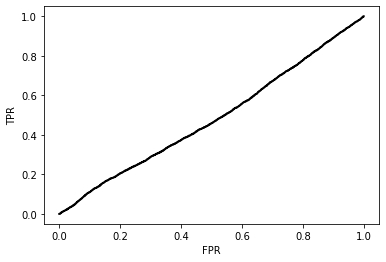

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09522179570361458
PR-AUC


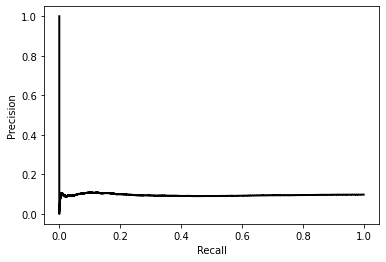

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10797375223702525
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.11947194719471947
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4829933161097351
ROC_AUC curve


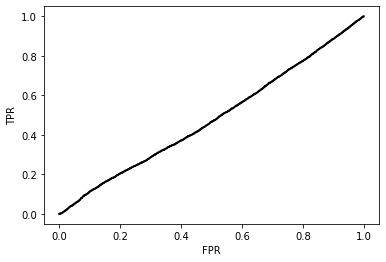

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.0951486653905117
PR-AUC


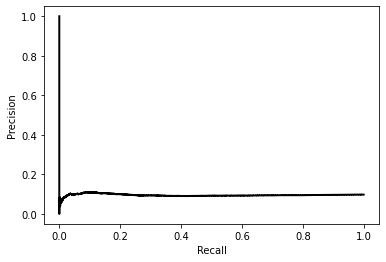

precision of Isolation Forest is 0.10658182541260688
recall of Isolation Forest is 0.11793179317931793
ROC of Isolation Forest is 0.48472428955930175
ROC_AUC curve


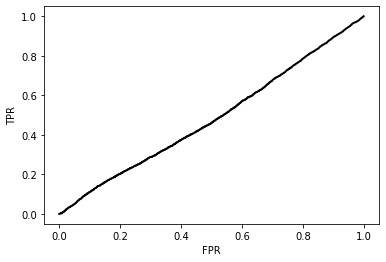

Precision-recall AUC of Isolation Forest is 0.09542979000824424
PR-AUC


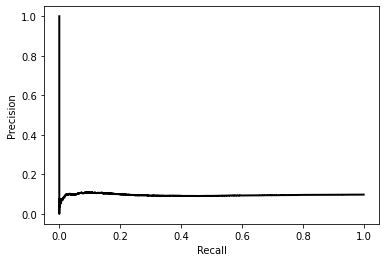

precision of Principal Component Analysis (PCA) Outlier Detector is 0.1067806721018095
recall of Principal Component Analysis (PCA) Outlier Detector is 0.11815181518151815
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5098064208001037
ROC_AUC curve


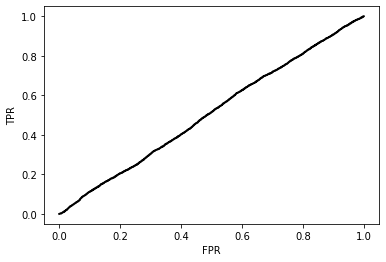

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09928665355194097
PR-AUC


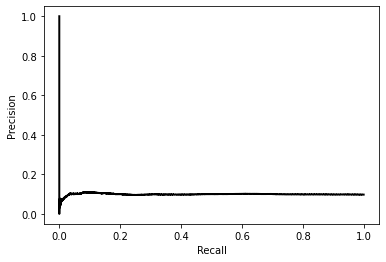

In [19]:
#@title
#@markdown <h3>⬅️p0.5q1</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.5q1.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10797375223702525
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.11947194719471947
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.48351166300142234
ROC_AUC curve


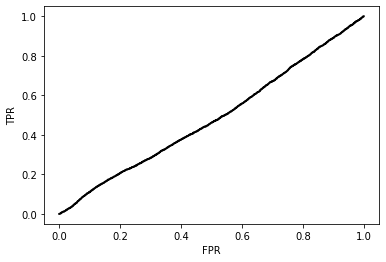

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09520324993341009
PR-AUC


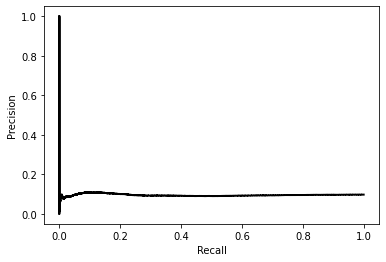

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10817259892622788
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.1196919691969197
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4831865651640487
ROC_AUC curve


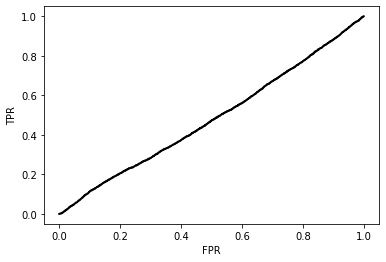

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09524057238973377
PR-AUC


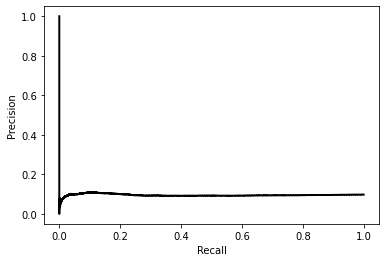

precision of Isolation Forest is 0.10757605885862001
recall of Isolation Forest is 0.11903190319031903
ROC of Isolation Forest is 0.48428958653022774
ROC_AUC curve


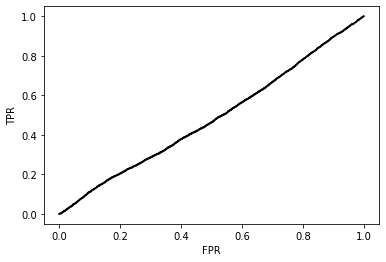

Precision-recall AUC of Isolation Forest is 0.09542381045789503
PR-AUC


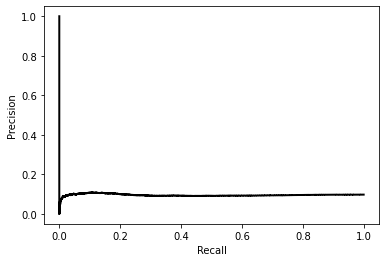

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10837144561543051
recall of Principal Component Analysis (PCA) Outlier Detector is 0.11991199119911991
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5081667413748682
ROC_AUC curve


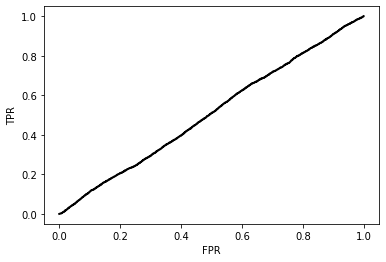

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09894749322415948
PR-AUC


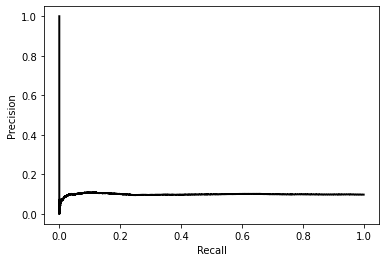

In [20]:
#@title
#@markdown <h3>⬅️p0.5q10</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.5q10.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10658182541260688
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.11793179317931793
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.48358877725988647
ROC_AUC curve


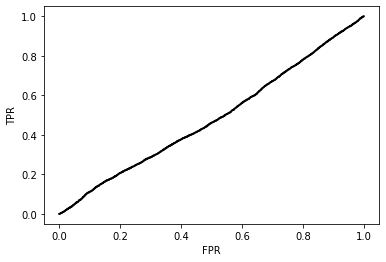

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09522010256671559
PR-AUC


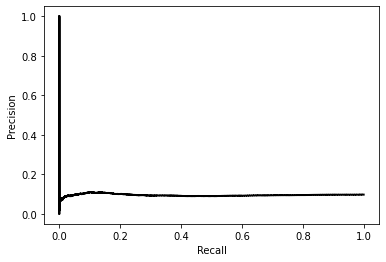

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10896798568303838
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.12057205720572058
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4840923631619213
ROC_AUC curve


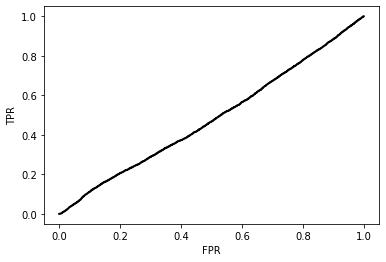

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09539504017475939
PR-AUC


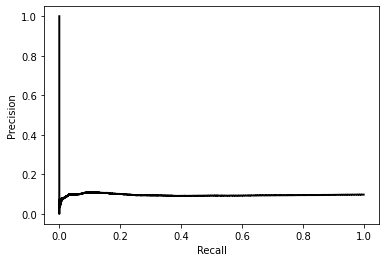

precision of Isolation Forest is 0.10837144561543051
recall of Isolation Forest is 0.11991199119911991
ROC of Isolation Forest is 0.484358540092568
ROC_AUC curve


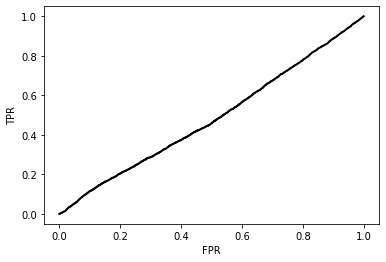

Precision-recall AUC of Isolation Forest is 0.09572237418328473
PR-AUC


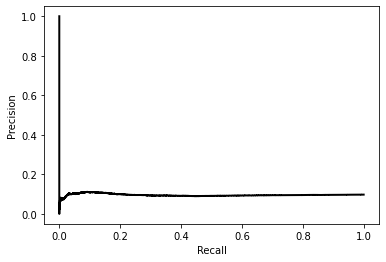

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10896798568303838
recall of Principal Component Analysis (PCA) Outlier Detector is 0.12057205720572058
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5105997022510982
ROC_AUC curve


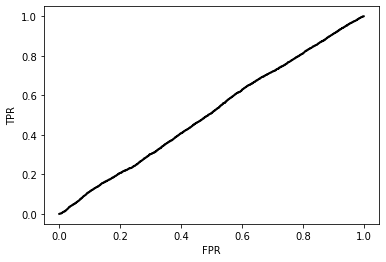

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09949162974127057
PR-AUC


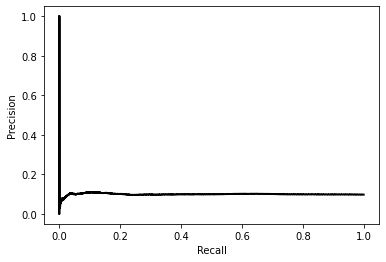

In [21]:
#@title
#@markdown <h3>⬅️p0.5q100</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.5q100.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10976337243984888
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.12145214521452145
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.4818007025005792
ROC_AUC curve


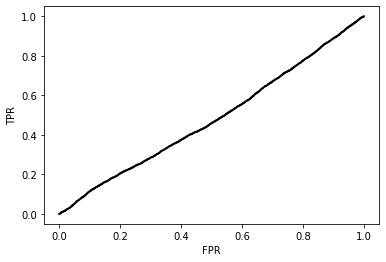

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09534658989291318
PR-AUC


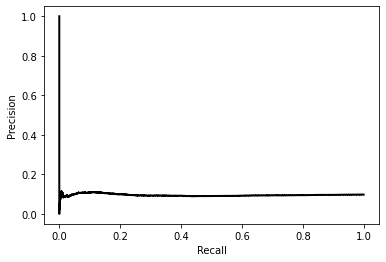

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10896798568303838
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.12057205720572058
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.48397579375729527
ROC_AUC curve


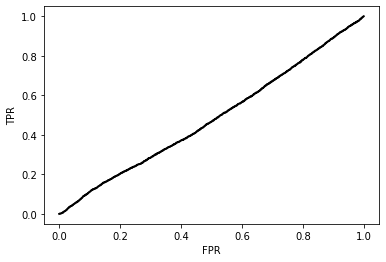

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09519863669779888
PR-AUC


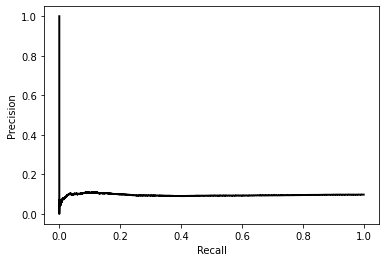

precision of Isolation Forest is 0.10658182541260688
recall of Isolation Forest is 0.11793179317931793
ROC of Isolation Forest is 0.4860416646867095
ROC_AUC curve


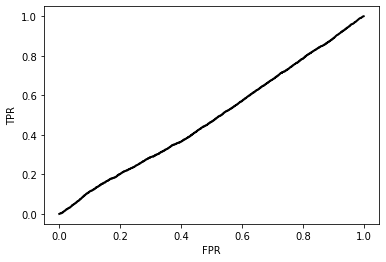

Precision-recall AUC of Isolation Forest is 0.0955199680531619
PR-AUC


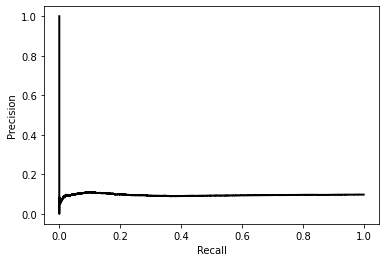

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10697951879101213
recall of Principal Component Analysis (PCA) Outlier Detector is 0.11837183718371837
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5089974986694034
ROC_AUC curve


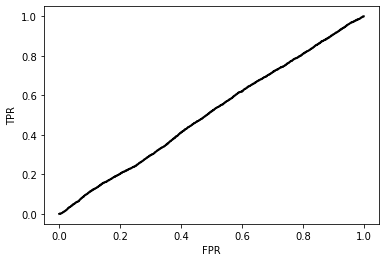

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09906014020262285
PR-AUC


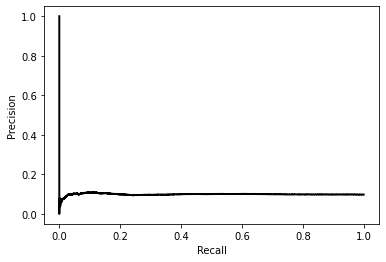

In [22]:
#@title
#@markdown <h3>⬅️p0.75q0.1</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.75q0.1.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10916683237224101
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.12079207920792079
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.4835201614356918
ROC_AUC curve


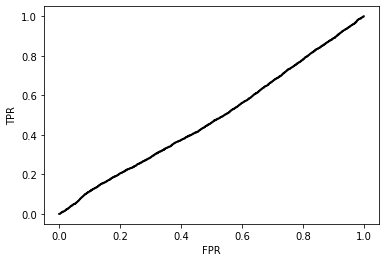

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.0956399288536173
PR-AUC


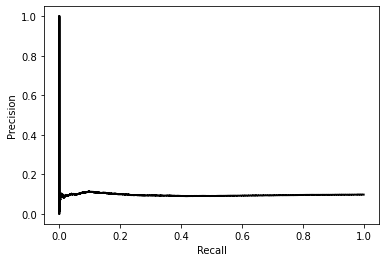

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10837144561543051
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.11991199119911991
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4844686610549248
ROC_AUC curve


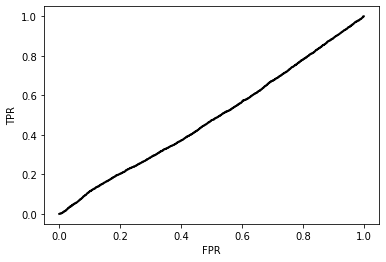

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09531337202971156
PR-AUC


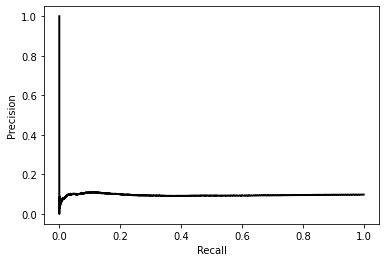

precision of Isolation Forest is 0.10837144561543051
recall of Isolation Forest is 0.11991199119911991
ROC of Isolation Forest is 0.4851697216652816
ROC_AUC curve


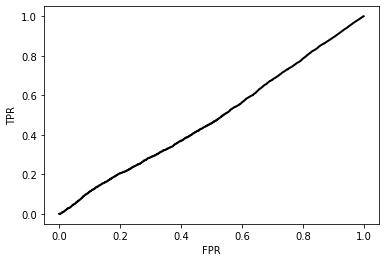

Precision-recall AUC of Isolation Forest is 0.09537406850422048
PR-AUC


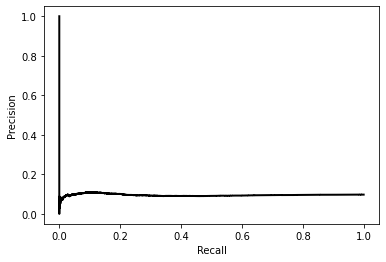

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10777490554782262
recall of Principal Component Analysis (PCA) Outlier Detector is 0.11925192519251925
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5100980066354288
ROC_AUC curve


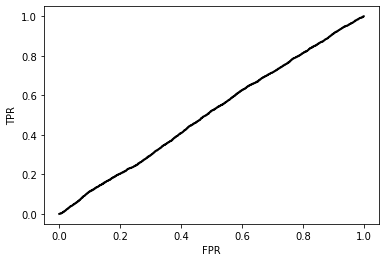

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09929598889885112
PR-AUC


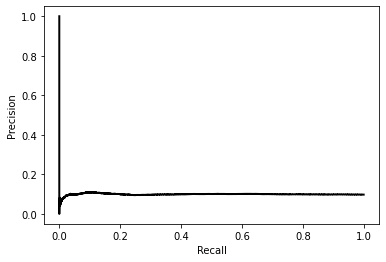

In [23]:
#@title
#@markdown <h3>⬅️p0.75q1</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.75q1.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10876913899383575
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.12035203520352035
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.48253156784775786
ROC_AUC curve


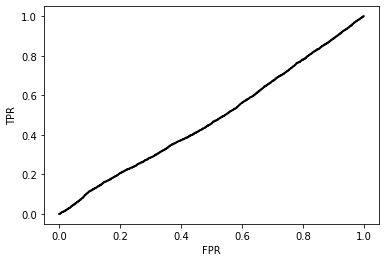

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09512635878459036
PR-AUC


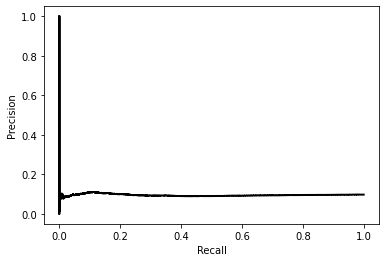

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10777490554782262
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.11925192519251925
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4835584698430337
ROC_AUC curve


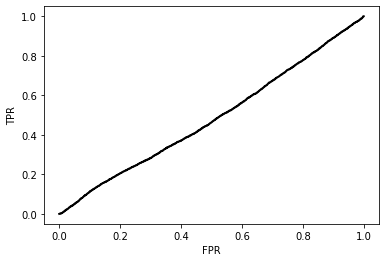

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.0951864498048695
PR-AUC


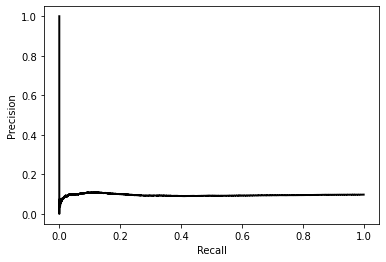

precision of Isolation Forest is 0.10837144561543051
recall of Isolation Forest is 0.11991199119911991
ROC of Isolation Forest is 0.4855681400977624
ROC_AUC curve


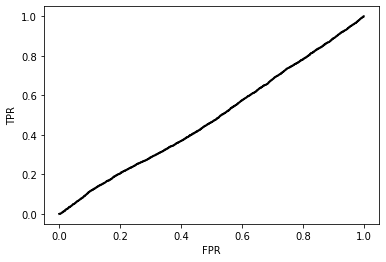

Precision-recall AUC of Isolation Forest is 0.09574466003097516
PR-AUC


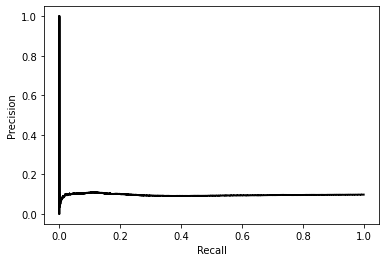

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10777490554782262
recall of Principal Component Analysis (PCA) Outlier Detector is 0.11925192519251925
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5105724528044322
ROC_AUC curve


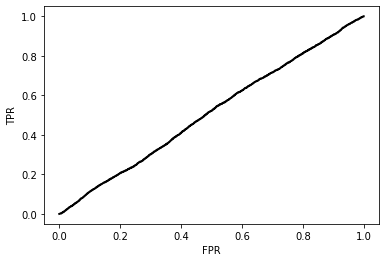

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09942428294434254
PR-AUC


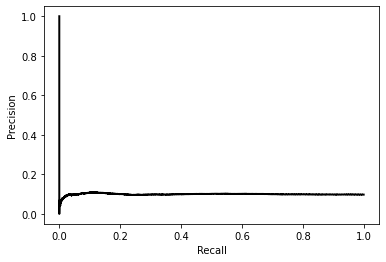

In [24]:
#@title
#@markdown <h3>⬅️p0.75q10</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.75q10.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10618413203420163
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.11749174917491749
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.48258002410822004
ROC_AUC curve


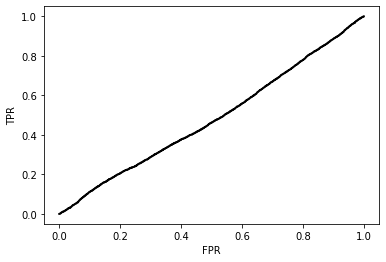

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09514238207076589
PR-AUC


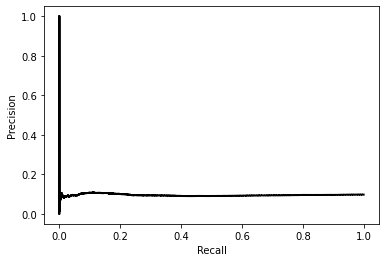

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10777490554782262
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.11925192519251925
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4844554971216201
ROC_AUC curve


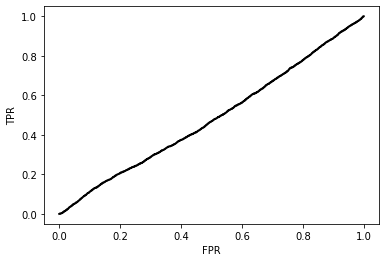

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09535736735513509
PR-AUC


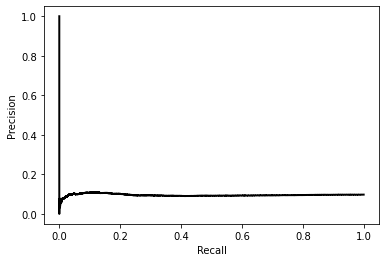

precision of Isolation Forest is 0.10737721216941738
recall of Isolation Forest is 0.1188118811881188
ROC of Isolation Forest is 0.4828759874488127
ROC_AUC curve


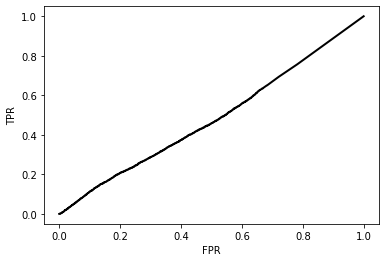

Precision-recall AUC of Isolation Forest is 0.09543982927554587
PR-AUC


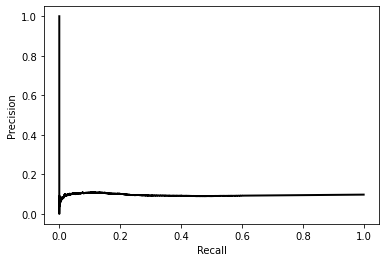

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10777490554782262
recall of Principal Component Analysis (PCA) Outlier Detector is 0.11925192519251925
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5102097534535099
ROC_AUC curve


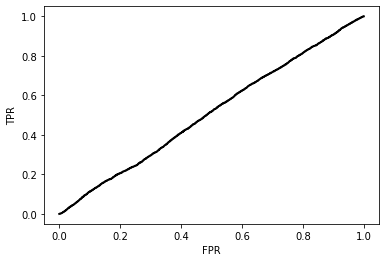

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09936629797609288
PR-AUC


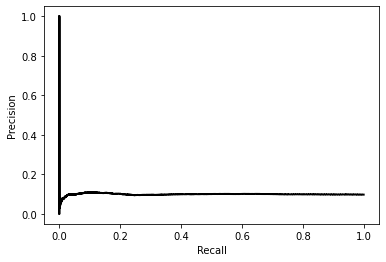

In [25]:
#@title
#@markdown <h3>⬅️p0.75q100</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp0.75q100.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10876913899383575
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.12035203520352035
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.48371461482757905
ROC_AUC curve


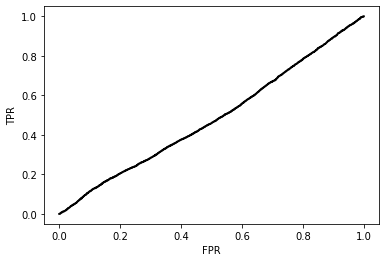

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09553020862853566
PR-AUC


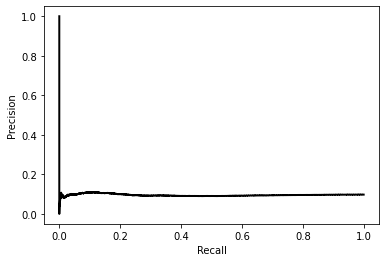

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10797375223702525
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.11947194719471947
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.48424837200395826
ROC_AUC curve


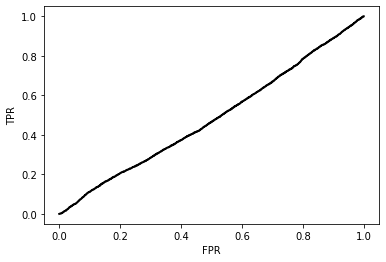

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.0951650425835658
PR-AUC


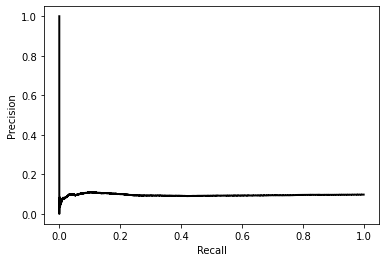

precision of Isolation Forest is 0.10717836548021475
recall of Isolation Forest is 0.1185918591859186
ROC of Isolation Forest is 0.48314122970877726
ROC_AUC curve


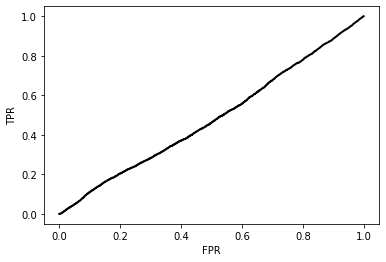

Precision-recall AUC of Isolation Forest is 0.09488817135035213
PR-AUC


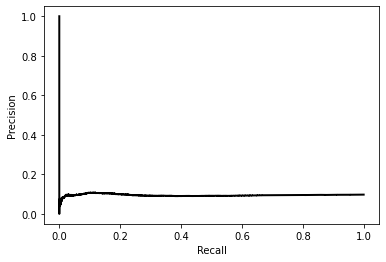

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10837144561543051
recall of Principal Component Analysis (PCA) Outlier Detector is 0.11991199119911991
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5084190134427898
ROC_AUC curve


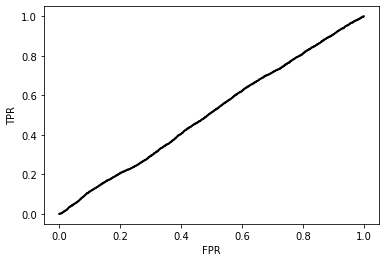

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09898101050561897
PR-AUC


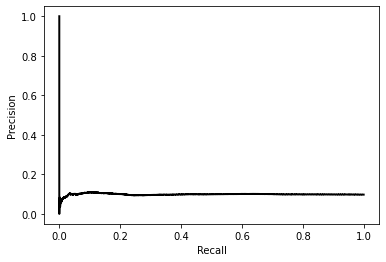

In [26]:
#@title
#@markdown <h3>⬅️p1q0.1</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp1q0.1.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10797375223702525
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.11947194719471947
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.48320175028997703
ROC_AUC curve


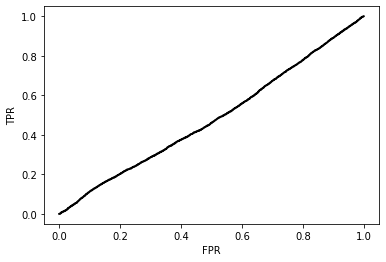

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09539579125701111
PR-AUC


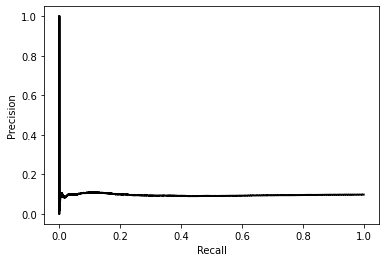

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10697951879101213
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.11837183718371837
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.4840393304186794
ROC_AUC curve


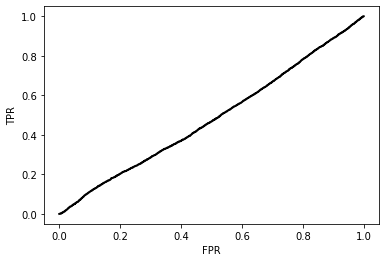

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.09514401602426836
PR-AUC


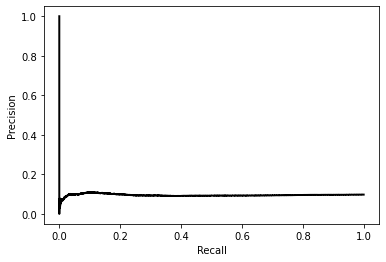

precision of Isolation Forest is 0.10618413203420163
recall of Isolation Forest is 0.11749174917491749
ROC of Isolation Forest is 0.4821332043959055
ROC_AUC curve


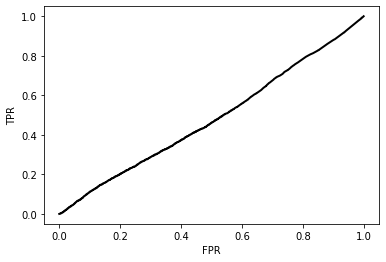

Precision-recall AUC of Isolation Forest is 0.09512350388931433
PR-AUC


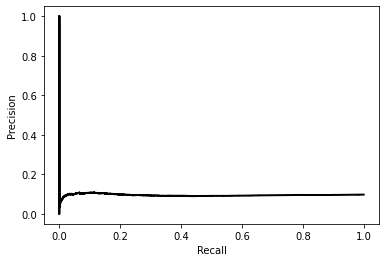

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10757605885862001
recall of Principal Component Analysis (PCA) Outlier Detector is 0.11903190319031903
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5084945306449064
ROC_AUC curve


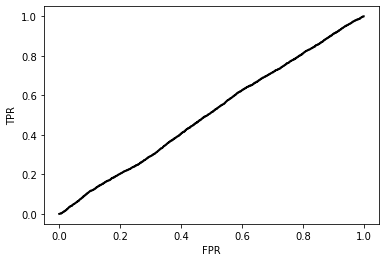

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09898815633358433
PR-AUC


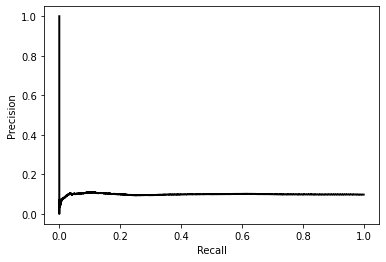

In [27]:
#@title
#@markdown <h3>⬅️p1q1</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp1q1.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10936567906144362
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.12101210121012101
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.4842350562193943
ROC_AUC curve


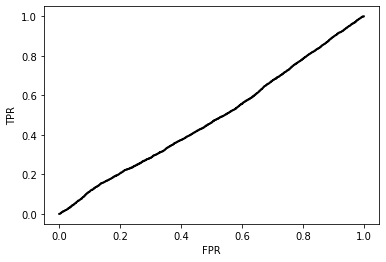

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.09563421115888482
PR-AUC


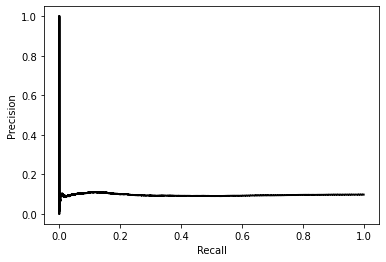

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10936567906144362
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.12101210121012101
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.48445713083171993
ROC_AUC curve


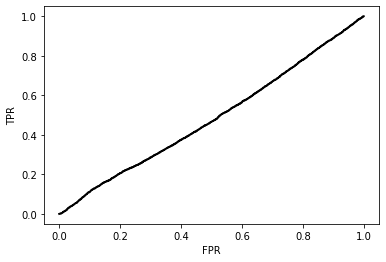

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.0952945449544047
PR-AUC


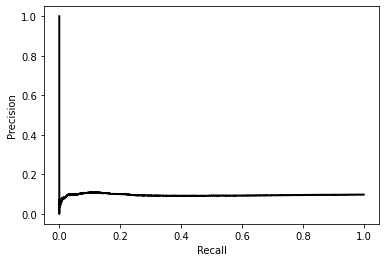

precision of Isolation Forest is 0.10876913899383575
recall of Isolation Forest is 0.12035203520352035
ROC of Isolation Forest is 0.4843016377603395
ROC_AUC curve


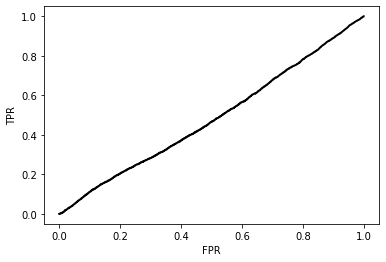

Precision-recall AUC of Isolation Forest is 0.09522504715604933
PR-AUC


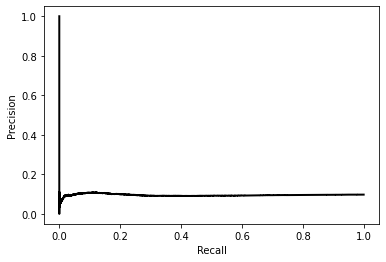

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10817259892622788
recall of Principal Component Analysis (PCA) Outlier Detector is 0.1196919691969197
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5098576889269879
ROC_AUC curve


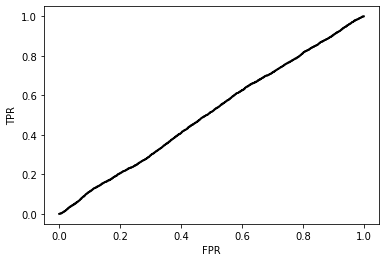

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09927889279958559
PR-AUC


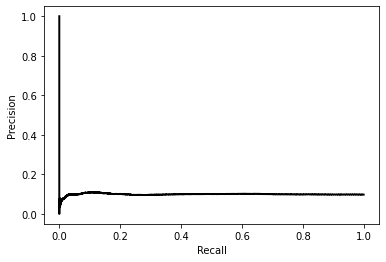

In [28]:
#@title
#@markdown <h3>⬅️p1q10</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp1q10.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

precision of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.10837144561543051
recall of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.11991199119911991
ROC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.48444369984964897
ROC_AUC curve


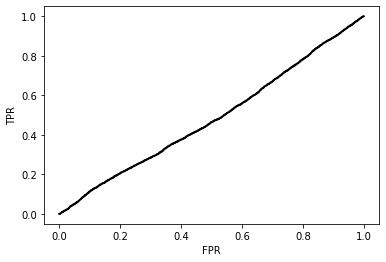

Precision-recall AUC of Outlier Detection with Minimum Covariance Determinant (MCD) is 0.0955770715721277
PR-AUC


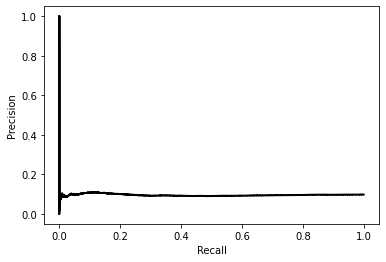

precision of Cluster-based Local Outlier Factor (CBLOF) is 0.10757605885862001
recall of Cluster-based Local Outlier Factor (CBLOF) is 0.11903190319031903
ROC of Cluster-based Local Outlier Factor (CBLOF) is 0.48414376219506333
ROC_AUC curve


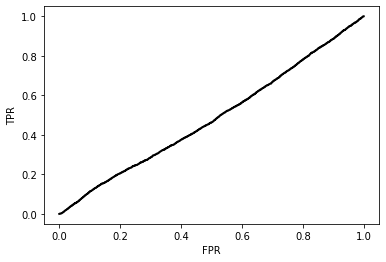

Precision-recall AUC of Cluster-based Local Outlier Factor (CBLOF) is 0.0953299554871688
PR-AUC


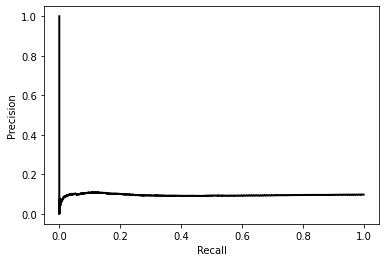

precision of Isolation Forest is 0.10717836548021475
recall of Isolation Forest is 0.1185918591859186
ROC of Isolation Forest is 0.4872920969719
ROC_AUC curve


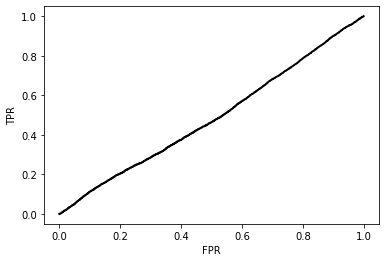

Precision-recall AUC of Isolation Forest is 0.09593062056310611
PR-AUC


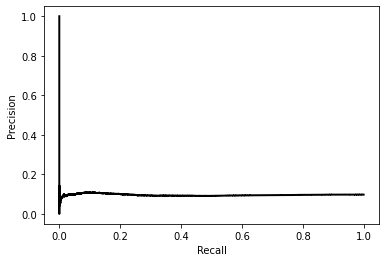

precision of Principal Component Analysis (PCA) Outlier Detector is 0.10876913899383575
recall of Principal Component Analysis (PCA) Outlier Detector is 0.12035203520352035
ROC of Principal Component Analysis (PCA) Outlier Detector is 0.5101416769630983
ROC_AUC curve


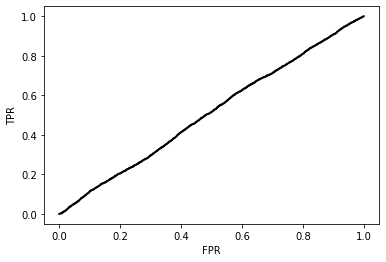

Precision-recall AUC of Principal Component Analysis (PCA) Outlier Detector is 0.09938008504803614
PR-AUC


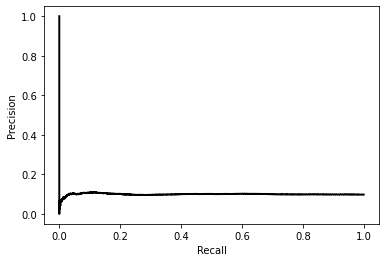

In [29]:
#@title
#@markdown <h3>⬅️p1q100</h3>
node2vec_pd=pd.read_csv('/content/drive/My Drive/Thesis/node2vecp1q100.csv')
y_num= classes['class']
y_num=y_num.replace('unknown', numpy.NaN)
y_num=y_num.replace('2','0' )
node2vec_pd['class']= y_num
node2vec_pd=node2vec_pd.dropna()
y_num= node2vec_pd['class']
y_num= y_num.to_frame()
del node2vec_pd['class']
del node2vec_pd['Unnamed: 0']
X=node2vec_pd
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc
outliers_fraction=0.108
random_state=123

classifiers = {
      "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
      #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
      'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
      'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
      "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

      }
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    y_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_scores = clf.decision_function(X)  # outlier scores
    y_num['class']=pd.to_numeric(y_num['class'])
    y_num['y_pred']= y_pred
    y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
    y_num['y_scores']=y_scores
    y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
    n_errors = (y_num['y_pred'] != y_num['class']).sum()
    print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
    print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
    print("ROC of {} is {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores'])))

    fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
    plt.plot(fpr, tpr, 'k-', lw=2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print("ROC_AUC curve")
    plt.show()
    lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
    print("Precision-recall AUC of {} is {}".format(clf_name,auc(lr_recall, lr_precision)))
    # summarize scores
    #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
    #pyplot.plot(lr_recall, lr_precision, marker='.')
    plt.plot(lr_recall, lr_precision, 'k-', lw=2)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    print('PR-AUC')
    # show the plot
    pyplot.show()

# Second Approach

In [ ]:
#@title
#@markdown <h3>⬅️Import Packages</h3>
!pip install node2vec
import matplotlib.pyplot as plt
import networkx as nx
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
from node2vec import Node2Vec
import node2vec
import numpy as np
import numpy
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,cohen_kappa_score,precision_score,recall_score,confusion_matrix
from sklearn.model_selection import ParameterGrid, ParameterSampler
from time import time
from sklearn.metrics import classification_report,recall_score,precision_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import itemfreq
import plotly.offline as py 
import plotly.graph_objs as go
!pip install eif
!pip install pyod
from pyod.models import *
from pyod.utils.example import *
import pandas as pd
import numpy as np
# Import unsupervised classification models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.cof import COF
from pyod.models.lmdd import LMDD
from pyod.models.loda import LODA
from pyod.models.loci import LOCI
from pyod.models.lscp import LSCP
from pyod.models.mcd import MCD
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sod import SOD
from pyod.models.so_gaal import SO_GAAL
from pyod.models.sos import SOS
from pyod.models.vae import VAE
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import auc

In [2]:
#Filtered nodes (labeled) and edges (edges connected directly to labeled nodes)  
!gdown --id 1MoaChoFfjgLj9BVVGI40GAtz_fNLxQZw
!gdown --id 1O2xIwxncSzzrpuB8FeMYo979LmBu9b8p

Downloading...
From: https://drive.google.com/uc?id=1MoaChoFfjgLj9BVVGI40GAtz_fNLxQZw
To: /content/nodes.csv
100% 587k/587k [00:00<00:00, 39.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1O2xIwxncSzzrpuB8FeMYo979LmBu9b8p
To: /content/edges_finalwoindex.csv
100% 2.04M/2.04M [00:00<00:00, 65.3MB/s]


In [ ]:
nodes=pd.read_csv('nodes.csv')

In [ ]:
edges = pd.read_csv('/content/edges_finalwoindex.csv',engine='python')
features = pd.read_csv('/content/elliptic_bitcoin_dataset/elliptic_txs_features.csv',engine='python',header=None)
classes = pd.read_csv('/content/elliptic_bitcoin_dataset/elliptic_txs_classes.csv',engine='python')

In [ ]:
#reference of https://www.kaggle.com/dhruvrnaik/illicit-transaction-detection
len(edges),len(features),len(classes)
display(edges.head(5),features.head(5),classes.head(5))

#defining features
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + tx_features + agg_features
features = pd.merge(features,classes,left_on="txId",right_on="txId",how='left')
features['class'] = features['class'].apply(lambda x: '0' if x == "unknown" else x)

#class counts
features.groupby('class').size()
count_by_class = features[["time_step",'class']].groupby(['time_step','class']).size().to_frame().reset_index()

#categorising the class
illicit_count = count_by_class[count_by_class['class'] == '1']
licit_count = count_by_class[count_by_class['class'] == '2']
unknown_count = count_by_class[count_by_class['class'] == "0"]

#Building graph
ids = features['txId']
short_edges = edges[edges['txId1'].isin(ids)]
graph = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())

# Grid search Node2vec and Anomaly detection

In [ ]:
i= [0.25,0.5,0.75,1]
j= [0.1,  1, 10, 100]

for p in i:
    for q in j:
        node2vec = Node2Vec(graph, dimensions = 128, p=p, q=q, 
                                        workers=1)
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        #extracting embeddings for anomaly detection
        node2vec_dict = {}
        for node in graph.nodes():
            node = str(node)
            node2vec_dict[node] = model.wv[node]
        
        node2vec_pd = pd.DataFrame.from_dict(node2vec_dict, orient='index')
        node2vec_pd.to_csv(r'/content/node2vecp{}q{}.csv'.format(p,q))
        node2vec_pd=pd.read_csv(r'/content/node2vecp{}q{}.csv'.format(p,q))
        node2vec_pd['bool']=node2vec_pd['Unnamed: 0'].isin(nodes.txId)
        nodes_final=node2vec_pd[node2vec_pd['bool']==True]
        nodes_final['txId']=nodes_final['Unnamed: 0']
        nodes_final=pd.merge(nodes_final, nodes, on ='txId', how ='inner')
        y_num= nodes_final['class']
        y_num=y_num.replace(2,0)
        y_num= y_num.to_frame()
        del nodes_final['Unnamed: 0']
        del nodes_final['bool']
        del nodes_final['txId']
        del nodes_final['class']
        X=nodes_final
        outliers_fraction=0.108
        random_state=123
        #anomaly detection using isolation and local outlier factor
        classifiers = {
        "Outlier Detection with Minimum Covariance Determinant (MCD)": MCD(contamination=outliers_fraction),
        #'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        "Principal Component Analysis (PCA) Outlier Detector": PCA(contamination=outliers_fraction),

        }
        for i, (clf_name,clf) in enumerate(classifiers.items()):
            #Fit the data and tag outliers
            clf.fit(X)
            # predict raw anomaly score
            scores_pred = clf.decision_function(X) * -1
                
            # prediction of a datapoint category outlier or inlier
            y_pred = clf.predict(X)
            n_inliers = len(y_pred) - np.count_nonzero(y_pred)
            n_outliers = np.count_nonzero(y_pred == 1)
            y_pred = clf.predict(X)  # outlier labels (0 or 1)
            y_scores = clf.decision_function(X)  # outlier scores
            y_num['class']=pd.to_numeric(y_num['class'])
            y_num['y_pred']= y_pred
            y_num['y_pred']=pd.to_numeric(y_num['y_pred'])
            y_num['y_scores']=y_scores
            y_num['y_scores']=pd.to_numeric(y_num['y_scores'])
            n_errors = (y_num['y_pred'] != y_num['class']).sum()
            print("precision of {} is {}".format(clf_name,precision_score( y_num['class'],y_num['y_pred'])))
            print("recall of {} is {}".format(clf_name,recall_score( y_num['class'],y_num['y_pred'])))
            print("ROC of {} is {} and p= {}, q= {}".format(clf_name,roc_auc_score( y_num['class'],y_num['y_scores']),p,q))

            fpr, tpr, thresholds = roc_curve(y_num['class'],y_num['y_scores'])
            plt.plot(fpr, tpr, 'k-', lw=2)
            plt.xlabel('FPR')
            plt.ylabel('TPR')
            print("ROC_AUC curve")
            plt.show()
            lr_precision, lr_recall, _  = precision_recall_curve(y_num['class'],y_num['y_scores'])
            print("Precision-recall AUC of {} is {} and p= {}, q= {}".format(clf_name,auc(lr_recall, lr_precision),p,q))
            # summarize scores
            #print('Logistic: f1=%.3f auc=%.3f'  lr_auc)
            #pyplot.plot(lr_recall, lr_precision, marker='.')
            plt.plot(lr_recall, lr_precision, 'k-', lw=2)
            # axis labels
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            # show the legend
            print('PR-AUC')
            # show the plot
            pyplot.show()        
                  